## Hybrid quantum-classical Neural Networks 


**Procedure** &nbsp;
Basically one or more hidden layers are being replaced by quantum circuits with tunable parameters; 
from its output a loss function is computed and optimized within the classical neural network code.
The specific implementation depends on the chosen neural network model.

A **neural network** is basically an elaborate function (<i>model</i>) composed of layers of small building blocks (<i>neurons</i>), 
which are typically simple, easy-to-compute, and nonlinear functions that map one or more inputs to a real number, which is fed as input into other neurons in subsequent layers. 
Graphically, we represent neurons as nodes in a graph with directed edges between nodes.
Usually each edge is associated with a scalar-valued weight, such that each input to a neuron is multiplied by a different weight before being processed into a single output value. The objective of training a neural network is primarily choosing the weights such that the network behaves in a particular way.

**Feed-Forward Neural Network (FFNN):** &nbsp; in this type of NN data flows from layer to layer without revisiting any neuron. Neurons within the same layer do not have edges between them. The graph describing such a neural network is a directed acyclic graph (DAG). <br>
Gradient building within a FFNN is implemented as evaluating neurons for shifted parameters within a backpropagation routine. In case of a hidden quantum layer, this quantum circuit must be processed twice with shifted parameters: $\nabla C_i(\theta)=C_i(\theta+s)-C_i(\theta-s)$. 


In [1]:
import qiskit
print("Qiskit version", qiskit.__version__)
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt

import torch
print("Torch version", torch.__version__)
from torch.autograd import Function
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn

from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=UserWarning)

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
    # torch.set_default_device(mps_device)
else:
    print ("MPS device not found.")

Qiskit version 1.4.2
Torch version 2.6.0.dev20241112


/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <A09E200C-3620-3399-800F-6831D2DFDFC0> /Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/addisonhanrattie

tensor([1.], device='mps:0')


In order to integrate the quantum code into the pyTorch framework, we define the quantum circuit and its interface to pyTorch as classes. <br>
This simple quantum circuit class implements the circuit $H^{\otimes n} R_y^{\otimes n}(\theta)\ M^{\otimes n}$ where $M^{\otimes n}=\braket{Z\otimes Z\otimes\dots\otimes Z}$ is the measurement operator in the computational basis (it returns the sampling approximation to the expectation value of $Z$).

In [2]:
## simple Circuit class to interface with the pyTorch model
## quantum circuit: H(all_qubits) Ry(theta,all_qubits) 
class MyCircuit:    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = list(range(n_qubits))
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        if not isinstance(thetas, (list,tuple,np.ndarray)):
            thetas = [thetas]
        qc = self._circuit.assign_parameters({"theta": thetas[0]})
        t_qc = transpile(qc, self.backend)
        res = self.backend.run(t_qc, shots=self.shots).result().get_counts()        
        counts = np.array(list(res.values()))
        states = np.array(list(res.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)        
        return np.array([expectation])


In [3]:
circ = MyCircuit(2, Aer.get_backend('aer_simulator'), shots=1000)
print(f'Expected value for rotation by pi: {circ.run([np.pi])[0]}')
circ._circuit.draw()

Expected value for rotation by pi: 5.666


┌───┐ ░ ┌───────────┐ ░ ┌─┐   
   q_0: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├───
        ├───┤ ░ ├───────────┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ Ry(theta) ├─░──╫─┤M├
        └───┘ ░ └───────────┘ ░  ║ └╥┘
meas: 2/═════════════════════════╩══╩═
                                 0  1

In [4]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z], dtype=torch.float32, device=mps_device)
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = [] # THIS WOULD BE PREALLOCATED
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right], device=mps_device, dtype=torch.float32) - torch.tensor([expectation_left], device=mps_device, dtype=torch.float32)
            gradients.append(gradient)
        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients], device=mps_device).T
        return torch.tensor([gradients], device=mps_device).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = MyCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [5]:
## initially load only the first 100 samples for two numbers
n_samples = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

labelA, labelB = 0,1
np.random.seed(0)

X_train = datasets.MNIST(root='/Users/addisonhanrattie/data', train=True, download=False,
                         transform=transform, target_transform=None)
print(f"Loaded {len(X_train)} images and labels")

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == labelA)[0][:n_samples], 
                np.where(X_train.targets == labelB)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

Loaded 60000 images and labels


In [6]:
n_samples_show = 6

def plot_images(n_samples,  # number of images to plot
                ncols=6,    # number of images in horizonal dir.
                data=None,  # dataset (structure/class with attributes 'data' (or 'image') and 'target' (or 'label')
                            #  default: if train_loader exist, use train_loader, otherwise X_train
                **kwargs):
    if data is not None:
        try:
            data_iter = iter(data)
        except:
            data = None
    if data is None:
        try:
            data_iter = iter(train_loader)
        except:
            data_iter = iter(X_train)
    if n_samples <= ncols:
        ncols = n_samples
    nrows = int(np.ceil(n_samples/ncols))
    if "figsize" in kwargs.keys():
        myfigsize = kwargs["figsize"]
        del kwargs["figsize"]
    else:
        myfigsize = (2*ncols, 1+2*nrows)    
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=myfigsize, **kwargs)
    axes = axes.ravel()
    for n in range(n_samples):
        data, target = data_iter.__next__()
        if not isinstance(target, (int, str, float)):
            target = target.item()
        axes[n].imshow(data[0].numpy().squeeze(), cmap='gray')
        axes[n].set_xticks([])
        axes[n].set_yticks([])
        axes[n].set_title("Labeled: {}".format(target))
    for n in range(n_samples, ncols*nrows):
        axes[n].plot()
        axes[n].axis('off')
        axes[n].set_xticks([])
        axes[n].set_yticks([])
    plt.tight_layout()
    plt.show

plot_images(n_samples_show, 5)

In [7]:
n_samples = 50

X_test = datasets.MNIST(root='~/data', train=False, download=False,
                        transform=transform)

idx = np.append(np.where(X_test.targets == labelA)[0][:n_samples], 
                np.where(X_test.targets == labelB)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)


In [10]:
model = Net()
model = model.to(mps_device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
loss_func = loss_func.to(mps_device)
loss = torch.tensor([0]).to(mps_device)
output = torch.tensor([0]).to(mps_device)

torch.set_default_dtype(torch.float32)
# torch.set_default_device(mps_device)

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    i = 0
    for data, target in train_loader:
        data, target = data.to(mps_device), target.to(mps_device)
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        # print(i)
        total_loss.append(loss.item())
        i += 1
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.8081
Training [10%]	Loss: -0.9277
Training [15%]	Loss: -0.9244
Training [20%]	Loss: -0.9424
Training [25%]	Loss: -0.9411
Training [30%]	Loss: -0.9511
Training [35%]	Loss: -0.9657
Training [40%]	Loss: -0.9652
Training [45%]	Loss: -0.9687
Training [50%]	Loss: -0.9750
Training [55%]	Loss: -0.9768
Training [60%]	Loss: -0.9801
Training [65%]	Loss: -0.9815
Training [70%]	Loss: -0.9842
Training [75%]	Loss: -0.9822
Training [80%]	Loss: -0.9853
Training [85%]	Loss: -0.9882
Training [90%]	Loss: -0.9881
Training [95%]	Loss: -0.9899
Training [100%]	Loss: -0.9906


In [13]:
loss

tensor(-0.9800, device='mps:0', grad_fn=<NllLossBackward0>)

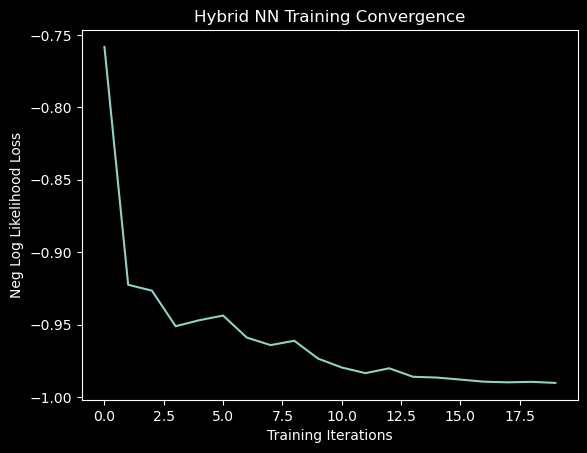

In [16]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')
plt.show()

In [26]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(mps_device), target.to(mps_device)
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss), correct / len(test_loader) * 100) )

Performance on test data:
	Loss: -0.9854
	Accuracy: 100.0%


In [37]:
n_samples_show = 12
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        data, target = data.to(mps_device), target.to(mps_device)
        
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].cpu().numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

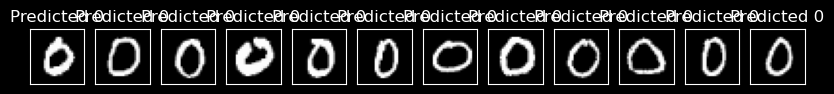

In [38]:
plt.show()